## Vision Transformer (ViT) architecture
Paper source: https://arxiv.org/abs/2010.11929

### Get setup, create datasets and dataloaders

In [1]:
# Checking versions of libraries for google colab: torch, torchvision

try:
    import torch
    import torchvision
    print(f'torch version: {torch.__version__}')
    print(f'torchvision version: {torchvision.__version__}')
    assert int(torch.__version__.split('.')[1]) >= 12, 'torch version should be 1.12+'
    assert int(torchvision.__version__.split('.')[1]) >= 13, 'torchvision version should be 0.13+'
except:
    print(f'[INFO] torch/torchvision versions not as required, installing required versions.')



torch version: 1.13.1
torchvision version: 0.14.1


In [2]:
# Bunch of imports

import torch
from torch import nn

import torchvision
from torchvision import transforms

from torchinfo import summary
from torchmetrics import Accuracy

import matplotlib.pyplot as plt

from pathlib import Path
import random

import sys
sys.path.insert(0, '..')
from python_scripts import data_setup, engine, model_builder, utils
from python_scripts.helper_functions import download_data, plot_loss_curves

In [3]:
# Checking GPU

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

In [4]:
# Constants and Hyper-parameters

BATCH_SIZE = 32
IMAGE_SIZE = 224

In [5]:
# Create datasets and dataloaders

image_path = Path('../data/extracted/pizza_steak_sushi_20_percent/')
train_dir = image_path / 'train'
test_dir = image_path / 'test'

manual_transforms = transforms.Compose([
    transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])
print(f'Manually created transforms: {manual_transforms}')

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    train_transform=manual_transforms,
    test_transform=manual_transforms,
    batch_size=BATCH_SIZE
)

print(f'Dataloaders created.\nlen(train_dataloader):{len(train_dataloader)},\nlen(test_dataloader): {len(test_dataloader)},\nclass_names: {class_names}')

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)
Dataloaders created.
len(train_dataloader):15,
len(test_dataloader): 5,
class_names: ['pizza', 'steak', 'sushi']


(-0.5, 223.5, 223.5, -0.5)

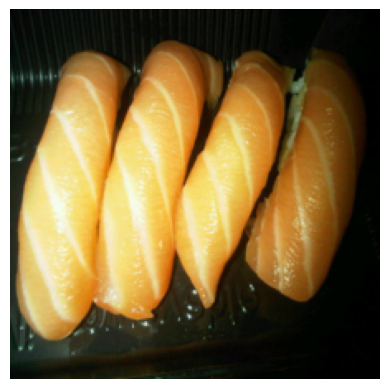

In [6]:
images, labels = next(iter(train_dataloader))
rand_number = random.randint(0, len(labels))
image = images[rand_number]
label = labels[rand_number]
plt.imshow(image.permute(1, 2, 0))
plt.axis(False)


## Eq.1
$$
\begin{aligned}
\mathbf{z}_{0} & =\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{p o s}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{p o s} \in \mathbb{R}^{(N+1) \times D} \\
\end{aligned}
$$

**pseudo code**
```
x_input = [class_token, image_patch_1, image_patch_2, ... image_patch_N] +
[class_token_pos, image_patch_1_pos, image_patch_2_pos, ... image_patch_N_pos]
```

In [7]:
# Split data into patches, and creating the class, position and patch embedding

height = 224
width = 224
color_channels = 3
patch_size = 16

number_of_patches = int(height * width / patch_size ** 2)

embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size ** 2 * color_channels)

print(f'Input shape (single 2D image): {embedding_layer_input_shape}')
print(f'Output shape (single 1D sequence of patches): {embedding_layer_output_shape}')

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768)


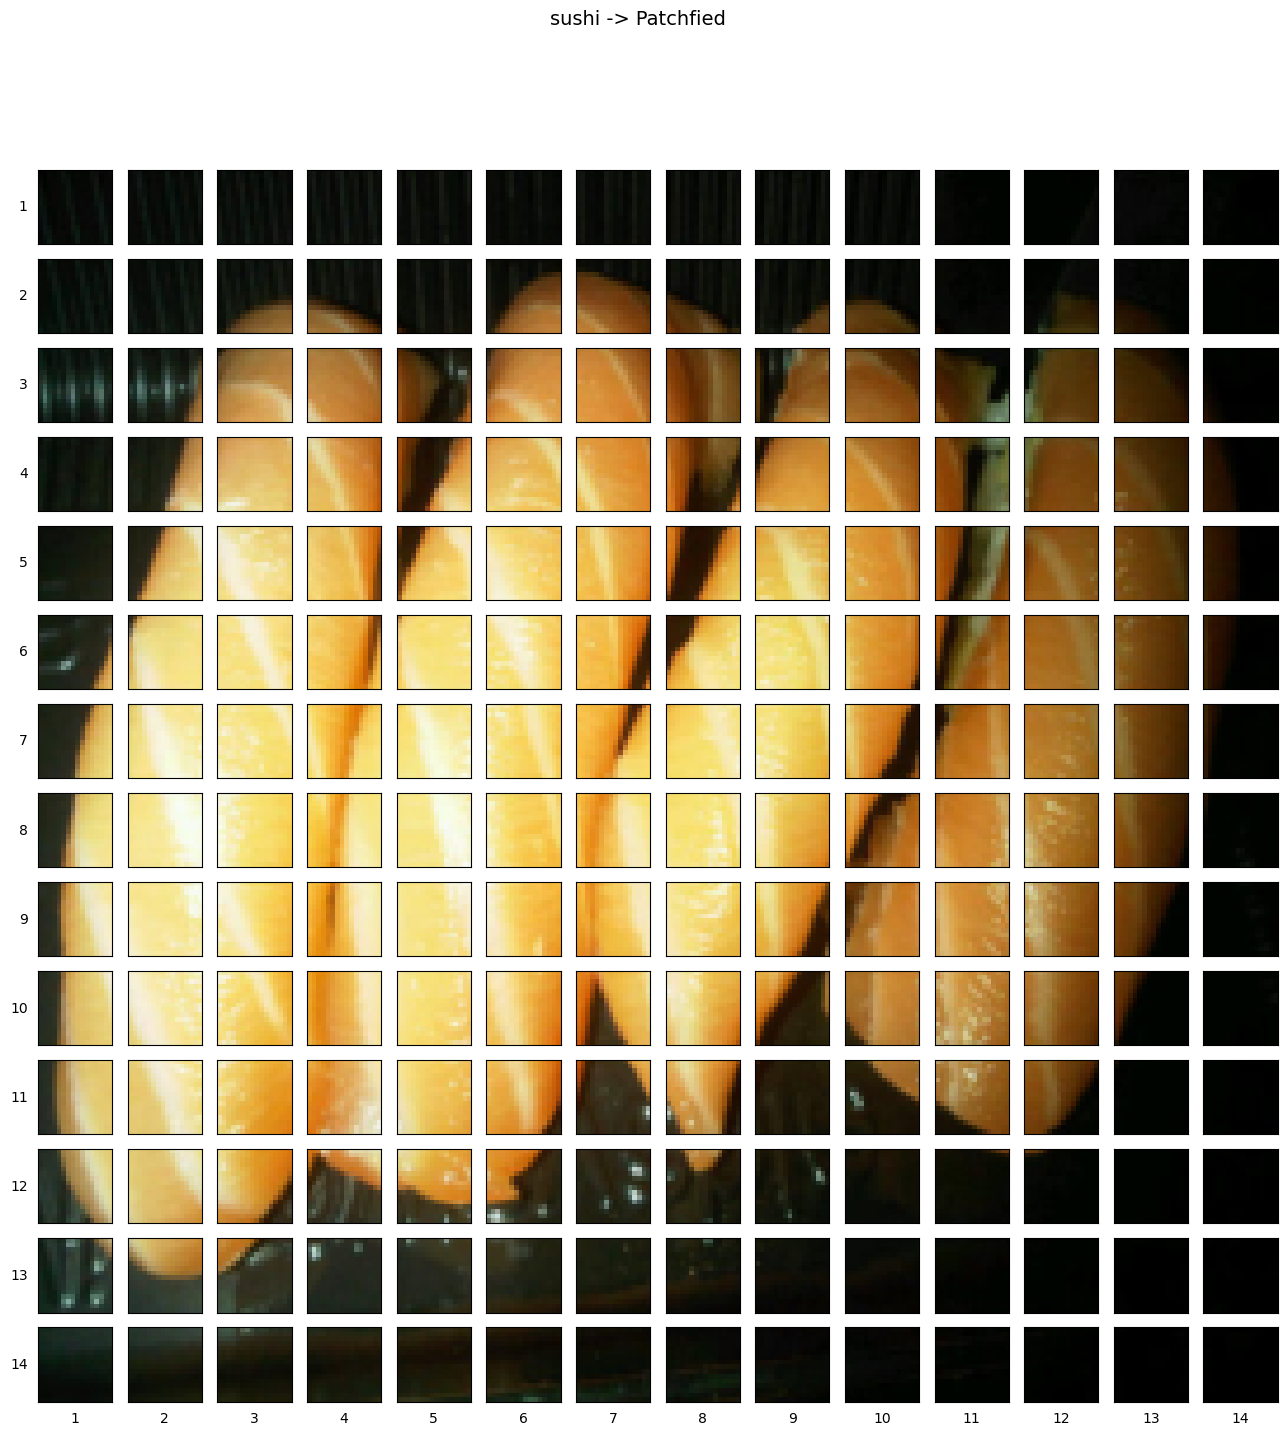

In [8]:
img_size = 224
patch_size = 16
n_patches = img_size // patch_size

fig, axs = plt.subplots(
    nrows=n_patches,
    ncols=n_patches,
    sharex=True,
    sharey=True,
    figsize=(patch_size, patch_size)
)

for i, ipatch in enumerate(range(0, img_size, patch_size)):
    for j, jpatch in enumerate(range(0, img_size, patch_size)):
        axs[i][j].imshow(image.permute(1, 2, 0)[ipatch:ipatch+patch_size, jpatch:jpatch+patch_size, :])
        axs[i][j].set_ylabel(
            i + 1,
            rotation='horizontal',
            horizontalalignment='right',
            verticalalignment='center'
        )
        axs[i][j].set_xlabel(j + 1)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        axs[i][j].label_outer()

fig.suptitle(f'{class_names[label]} -> Patchfied', fontsize=14)
plt.show()

In [9]:
# Create conv2d layer to turn image into patches of learnable feature maps

patch_size = 16

conv2d = nn.Conv2d(
    in_channels=3,
    out_channels=768,
    kernel_size=patch_size,
    stride=patch_size,
    padding=0
)

image_out_of_conv = conv2d(image.unsqueeze(dim=0))

flatten_layer = nn.Flatten(
    start_dim=2,
    end_dim=3
)

image_out_of_flatten = flatten_layer(image_out_of_conv)
image_out_of_flatten_permuted = image_out_of_flatten.permute(0, 2, 1)

single_flatten_feature_map = image_out_of_flatten_permuted[:, :, 0]
print(single_flatten_feature_map.shape)
plt.imshow(single_flatten_feature_map.detach().numpy())
plt.axis(False)


torch.Size([1, 196])


(-0.5, 195.5, 0.5, -0.5)

In [10]:
torch.manual_seed(42)

patchify = model_builder.PatchEmbedding(
    in_channels=3,
    patch_size=16,
    embedding_dim=768
)

print(f'Input image size: {image.unsqueeze(dim=0).shape}')
patch_embedded_image = patchify(image.unsqueeze(dim=0))
print(f'Output patch embedding sequence shape: {patch_embedded_image.shape}')

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])


In [11]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

class_token = nn.Parameter(
    data=torch.ones(batch_size, 1, embedding_dimension),
    requires_grad=True
)

patch_embedded_image_with_class_embedding = torch.cat(
    tensors=[class_token, patch_embedded_image],
    dim=1
)

print(patch_embedded_image_with_class_embedding)
print(f'{patch_embedded_image_with_class_embedding.shape} -> (batch_size, class_token+number_of_patches, embedding_dim)')

tensor([[[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         [-6.2722e-02,  6.8274e-04, -4.5805e-02,  ...,  4.2859e-02,
          -2.9441e-02,  2.8757e-02],
         [-6.2973e-02,  1.1504e-02, -5.7682e-02,  ...,  4.9101e-02,
          -2.9932e-02,  1.8113e-02],
         ...,
         [-2.1967e-02, -1.4111e-02, -3.4213e-02,  ...,  1.1110e-02,
          -7.2955e-03,  6.2294e-03],
         [-2.0652e-02, -7.2635e-03, -3.0194e-02,  ...,  1.0811e-02,
          -5.9496e-03,  4.3646e-03],
         [-1.9832e-02, -1.2085e-02, -3.0309e-02,  ...,  1.1839e-02,
          -4.8375e-03,  6.3480e-03]]], grad_fn=<CatBackward0>)
torch.Size([1, 197, 768]) -> (batch_size, class_token+number_of_patches, embedding_dim)


In [12]:
position_embedding = nn.Parameter(torch.ones(1, number_of_patches + 1, embedding_dimension), requires_grad=True)
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding.shape)

torch.Size([1, 197, 768])


In [13]:
# Putting all together for Equation 1

torch.manual_seed(42)

patch_size = 16

print(f'Image tensor shape: {image.shape}')
height, width = image.shape[1], image.shape[2]

x = image.unsqueeze(dim=0)
print(f'Input image shape: {x.shape}')

patch_embedding_layer = model_builder.PatchEmbedding(
    in_channels=3,
    patch_size=patch_size,
    embedding_dim=768
)
patch_embedding = patch_embedding_layer(x)
print(f'Patch embedding shape: {patch_embedding.shape}')

batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(
    torch.ones(batch_size, 1, embedding_dimension),
    requires_grad=True
)
print(f'Class token embedding shape: {class_token.shape}')

patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f'Patch embedding with class token shape: {patch_embedding_class_token.shape}')

number_of_patches = int(height * width / patch_size ** 2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches + 1, embedding_dimension))

patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f'Patch and position embedding shape: {patch_and_position_embedding.shape}')

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## Eq.2&3
$$
\begin{aligned}
\mathbf{z}_{\ell}^{\prime} & =\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \\
\mathbf{z}_{\ell} & =\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\
\end{aligned}
$$

**pseudo code**
```
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input
x_output_MLP_block = MPL_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```

In [14]:
msa_block = model_builder.MultiHeadSelfAttentionBlock(
    embedding_dim=768,
    num_heads=12,
    attn_dropout=0
)

mlp_block = model_builder.MultiLayerPerceptronBlock(
    embedding_dim=768,
    mlp_size=3072,
    dropout=0.1
)

patched_image_through_msa_block = msa_block(patch_and_position_embedding)
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)

print(patched_image_through_msa_block.shape)
print(patched_image_through_mlp_block.shape)

torch.Size([1, 197, 768])
torch.Size([1, 197, 768])


In [15]:
torch.manual_seed(42)

transformer_encoder_block = model_builder.TransformerEncoderBlock()

summary(
    model=transformer_encoder_block,
    input_size=(1, 197, 768),
    col_names=['input_size', 'output_size', 'num_params', 'trainable'],
    col_width=20,
    row_settings=['var_names']
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MultiLayerPerceptronBlock (mlp_block)            [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp_layer)                      [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [16]:
torch.manual_seed(42)

torch_transformerencoder_layer = nn.TransformerEncoderLayer(
    d_model=768,
    nhead=12,
    dim_feedforward=3072,
    dropout=0.1,
    activation='gelu',
    batch_first=True,
    norm_first=True,
)

summary(
    model=torch_transformerencoder_layer,
    input_size=(1, 197, 768),
    col_names=['input_size', 'output_size', 'num_params', 'trainable'],
    col_width=20,
    row_settings=['var_names']
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

## Eq.4
$$
\begin{aligned}
\mathbf{y} & =\operatorname{LN}\left(\mathbf{z}_{L}^{0}\right) & &
\end{aligned}
$$

### Replicated model info VS pretrained torchvision model info

In [21]:
# Putting all together

torch.manual_seed(42)

vit = model_builder.ViT(
    num_classes=len(class_names)
)

print(vit(image.unsqueeze(dim=0)))

summary(
    model=vit,
    input_size=(1, 3, 224, 224),
    col_names=['input_size', 'output_size', 'num_params', 'trainable'],
    col_width=20,
    row_settings=['var_names']
)

tensor([[-0.3706,  0.4046,  0.6891]], grad_fn=<AddmmBackward0>)


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer)                                   [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

In [42]:
pretrained_vit_weight = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weight)

for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

pretrained_vit.heads = nn.Linear(
    in_features=768,
    out_features=len(class_names)
)

summary(
    model=pretrained_vit,
    input_size=(1, 3, 224, 224),
    col_names=['input_size', 'output_size', 'num_params', 'trainable'],
    col_width=20,
    row_settings=['var_names']
)



Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### Training comparison between models

In [23]:
ViT_results = engine.train_tensorboard(
    model=vit,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(
        params=vit.parameters(),
        lr=1e-3,
        betas=(0.9, 0.999),
        weight_decay=0.1
    ),
    accuracy_fn=Accuracy(task='multiclass', num_classes=len(class_names)),
    epochs=10,
    device=device,
    writer=utils.create_writer(
        experiment_name='Rep_ViT_paper',
        model_name='ViT_architecture'
    )
)

ViT_results

[INFO] Created SummaryWriter saving to ../runs/2023-02-15/Rep_ViT_paper/ViT_architecture


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train_loss: 2.6979, Train_acc: 0.3292 | Test_loss: 1.8257, Test_acc: 0.2875


/Users/tglim/pytorch/Paper Replicating/notebook_scripts/../python_scripts/model_builder.py:85: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert image_resolution % self.patch_size == 0, f'Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}'


Epoch: 1 | Train_loss: 1.3867, Train_acc: 0.3792 | Test_loss: 1.3742, Test_acc: 0.3625
Epoch: 2 | Train_loss: 1.1935, Train_acc: 0.3313 | Test_loss: 1.1505, Test_acc: 0.2875
Epoch: 3 | Train_loss: 1.1382, Train_acc: 0.3229 | Test_loss: 1.1112, Test_acc: 0.3625
Epoch: 4 | Train_loss: 1.0987, Train_acc: 0.3521 | Test_loss: 1.2152, Test_acc: 0.2875
Epoch: 5 | Train_loss: 1.1196, Train_acc: 0.3146 | Test_loss: 1.1395, Test_acc: 0.3500
Epoch: 6 | Train_loss: 1.1232, Train_acc: 0.4104 | Test_loss: 1.8025, Test_acc: 0.2875
Epoch: 7 | Train_loss: 1.1867, Train_acc: 0.3104 | Test_loss: 1.1383, Test_acc: 0.3625
Epoch: 8 | Train_loss: 1.1557, Train_acc: 0.2917 | Test_loss: 1.3702, Test_acc: 0.2875
Epoch: 9 | Train_loss: 1.1552, Train_acc: 0.3167 | Test_loss: 1.1707, Test_acc: 0.3500


{'train_loss': [array(2.6979423, dtype=float32),
  array(1.3867375, dtype=float32),
  array(1.1934674, dtype=float32),
  array(1.1381866, dtype=float32),
  array(1.098666, dtype=float32),
  array(1.1195704, dtype=float32),
  array(1.1231692, dtype=float32),
  array(1.1866596, dtype=float32),
  array(1.1557167, dtype=float32),
  array(1.1551919, dtype=float32)],
 'train_acc': [array(0.32916668, dtype=float32),
  array(0.37916666, dtype=float32),
  array(0.33125, dtype=float32),
  array(0.32291666, dtype=float32),
  array(0.35208333, dtype=float32),
  array(0.31458333, dtype=float32),
  array(0.41041666, dtype=float32),
  array(0.31041667, dtype=float32),
  array(0.29166666, dtype=float32),
  array(0.31666666, dtype=float32)],
 'test_loss': [array(1.8256634, dtype=float32),
  array(1.3742298, dtype=float32),
  array(1.1505145, dtype=float32),
  array(1.11119, dtype=float32),
  array(1.2152048, dtype=float32),
  array(1.1395496, dtype=float32),
  array(1.8025032, dtype=float32),
  array(1

In [43]:
pretrained_vit_transforms = pretrained_vit_weight.transforms()

train_dataloader_pretrained, test_dataloader_pretrained, _ = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    train_transform=pretrained_vit_transforms,
    test_transform=pretrained_vit_transforms,
    batch_size=BATCH_SIZE
)

In [44]:
pretrained_ViT_results = engine.train_tensorboard(
    model=pretrained_vit,
    train_dataloader=train_dataloader_pretrained,
    test_dataloader=test_dataloader_pretrained,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(
        params=pretrained_vit.parameters(),
        lr=1e-3,
        betas=(0.9, 0.999),
        weight_decay=0.1
    ),
    accuracy_fn=Accuracy(task='multiclass', num_classes=len(class_names)),
    epochs=10,
    device=device,
    writer=utils.create_writer(
        experiment_name='Rep_ViT_paper',
        model_name='ViT_architecture',
        extra='pretrained_model'
    )
)

pretrained_ViT_results

[INFO] Created SummaryWriter saving to ../runs/2023-02-16/Rep_ViT_paper/ViT_architecture/pretrained_model


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train_loss: 0.5932, Train_acc: 0.8146 | Test_loss: 0.2304, Test_acc: 0.9812
Epoch: 1 | Train_loss: 0.2065, Train_acc: 0.9521 | Test_loss: 0.1240, Test_acc: 0.9812
Epoch: 2 | Train_loss: 0.1442, Train_acc: 0.9625 | Test_loss: 0.0990, Test_acc: 0.9875
Epoch: 3 | Train_loss: 0.1223, Train_acc: 0.9646 | Test_loss: 0.0919, Test_acc: 0.9875
Epoch: 4 | Train_loss: 0.1029, Train_acc: 0.9688 | Test_loss: 0.0820, Test_acc: 0.9875
Epoch: 5 | Train_loss: 0.0931, Train_acc: 0.9812 | Test_loss: 0.0791, Test_acc: 0.9812
Epoch: 6 | Train_loss: 0.0933, Train_acc: 0.9854 | Test_loss: 0.0772, Test_acc: 0.9875
Epoch: 7 | Train_loss: 0.0769, Train_acc: 0.9833 | Test_loss: 0.0752, Test_acc: 0.9937
Epoch: 8 | Train_loss: 0.0722, Train_acc: 0.9917 | Test_loss: 0.0737, Test_acc: 0.9812
Epoch: 9 | Train_loss: 0.0662, Train_acc: 0.9917 | Test_loss: 0.0726, Test_acc: 0.9812


{'train_loss': [array(0.59323055, dtype=float32),
  array(0.20652989, dtype=float32),
  array(0.14418927, dtype=float32),
  array(0.12234592, dtype=float32),
  array(0.10293241, dtype=float32),
  array(0.09307379, dtype=float32),
  array(0.09333889, dtype=float32),
  array(0.07685845, dtype=float32),
  array(0.07219947, dtype=float32),
  array(0.06622374, dtype=float32)],
 'train_acc': [array(0.81458336, dtype=float32),
  array(0.95208335, dtype=float32),
  array(0.9625, dtype=float32),
  array(0.96458334, dtype=float32),
  array(0.96875, dtype=float32),
  array(0.98125, dtype=float32),
  array(0.98541665, dtype=float32),
  array(0.98333335, dtype=float32),
  array(0.9916667, dtype=float32),
  array(0.9916667, dtype=float32)],
 'test_loss': [array(0.2304111, dtype=float32),
  array(0.12399614, dtype=float32),
  array(0.09900092, dtype=float32),
  array(0.0918838, dtype=float32),
  array(0.08202539, dtype=float32),
  array(0.07906927, dtype=float32),
  array(0.07716667, dtype=float32),


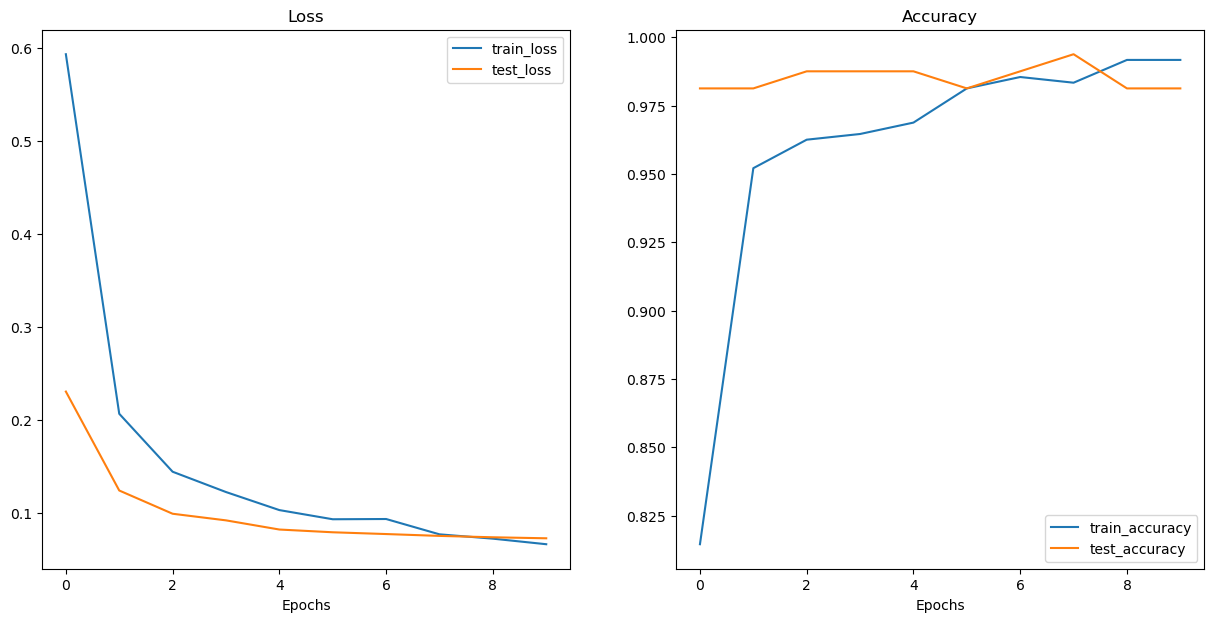

In [45]:
plot_loss_curves(pretrained_ViT_results)

In [47]:
utils.save_model(
    model=pretrained_vit,
    target_dir='../models',
    model_name='pretrained_vit_feature_extractor_pizza_steak_sushi.pth'
)

pretrained_vit_model_size = Path('../models/pretrained_vit_feature_extractor_pizza_steak_sushi.pth').stat().st_size // (1024*1024)
print(f'Pretrained ViT feature model size: {pretrained_vit_model_size} MB')

[INFO] Saving model to: ../models/pretrained_vit_feature_extractor_pizza_steak_sushi.pth
Pretrained ViT feature model size: 327 MB
